In [1]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.merge import merge

import torch
from torch.utils.data import Dataset, DataLoader
import models
from models.help_funcs import Transformer, TransformerDecoder, TwoLayerConv2d
from models.BIT import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model = define_G(net_G='base_transformer_pos_s4_dd8', input_nc=3)
model = torch.load("models_checkpoints/BIT_final_refined.pth", weights_only=False, map_location=torch.device('cpu'))
model.eval()

initialize network with normal


BASE_Transformer(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [3]:
# Helper function for gamma correction
def gamma_correction(rgb_image, gamma=0.8):
    """Apply gamma correction to enhance brightness and contrast."""
    return np.power(rgb_image, 1 / gamma)

# Helper function for saturation adjustment
def adjust_saturation(rgb_image, factor=1.2):
    """Adjust the saturation of the RGB image."""
    grayscale = np.mean(rgb_image, axis=0)  # Get the luminance (mean of R, G, B)
    return np.clip((rgb_image - grayscale) * factor + grayscale, 0, 1)  # Adjust and clip

def scale_rgb_image(rgb_image):

    # Applies a percentile stretch to the band array for better contrast
    # rgb_image = np.array([percentile_stretch(rgb_image[i], upper_percentile=98) for i in range(3)])

     # Normalize the image to the range 0-1 for display
    rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))
    
    # # Apply gamma correction
    rgb_image = gamma_correction(rgb_image, gamma=1.5)
    
    # # Adjust saturation for more vivid colors
    rgb_image = adjust_saturation(rgb_image, factor=1.1)
    
    # Convert the image to the range 0-255
    rgb_image = (rgb_image * 255).astype(np.uint8)

    return rgb_image

In [4]:
class SentinelChangeDataset(Dataset):
    def __init__(self, pre_dir, post_dir, patch_size=256, stride=128, transform=None):
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform
        
        self.pre_scenes = self._group_bands(pre_dir)
        self.post_scenes = self._group_bands(post_dir)

        # Generate patch coordinates with overlap
        self.patch_coords = []
        for idx in range(len(self.pre_scenes)):
            with rasterio.open(self.pre_scenes[idx]['B04']) as src:
                h, w = src.height, src.width
                for y in range(0, h, self.stride):
                    for x in range(0, w, self.stride):
                        # Handle the case where patches extend beyond the image
                        if y + patch_size > h:
                            y = h - patch_size
                        if x + patch_size > w:
                            x = w - patch_size
                        self.patch_coords.append((idx, y, x))

    def _group_bands(self, folder):
        import os
        from collections import defaultdict

        grouped = defaultdict(dict)
        for fname in sorted(os.listdir(folder)):
            if not fname.endswith(".tif"):
                continue
            for band in ['B04', 'B03', 'B02']:
                if band in fname:
                    scene_id = "_".join(fname.split("_")[:-1])  # customize as needed
                    grouped[scene_id][band] = os.path.join(folder, fname)
        return list(grouped.values())

    def __len__(self):
        return len(self.patch_coords)

    def __getitem__(self, idx):
        import rasterio
        import torch
        import numpy as np

        scene_id, y, x = self.patch_coords[idx]

        def read_patch(band_paths):
            patch = []
            for b in ['B04', 'B03', 'B02']:  # Ensure order
                with rasterio.open(band_paths[b]) as src:
                    window = rasterio.windows.Window(x, y, self.patch_size, self.patch_size)
                    patch.append(src.read(1, window=window))
            patch = np.stack(patch)  # shape: (3, H, W)
            patch = np.clip(patch / 15000.0, 0, 1)
            return torch.tensor(patch, dtype=torch.float32)

        pre_patch = read_patch(self.pre_scenes[scene_id])
        post_patch = read_patch(self.post_scenes[scene_id])

        if self.transform:
            pre_patch = self.transform(pre_patch)
            post_patch = self.transform(post_patch)

        return pre_patch, post_patch

        
dataset = SentinelChangeDataset(pre_dir='data/eo_data_new/pre_change', post_dir='data/eo_data_new/post_change', patch_size=256)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)

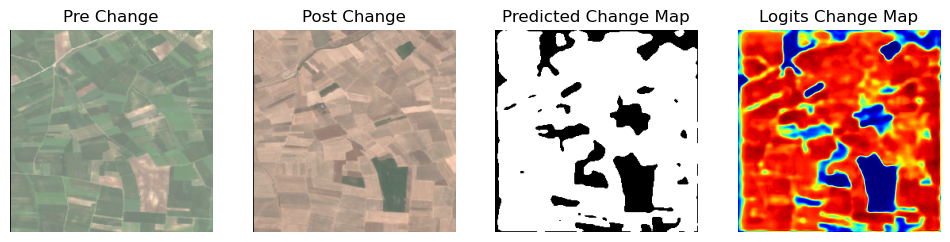

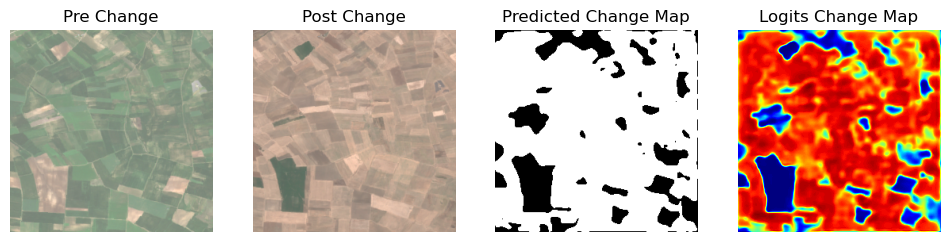

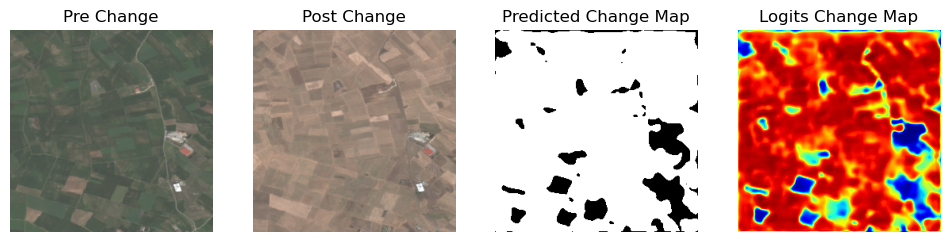

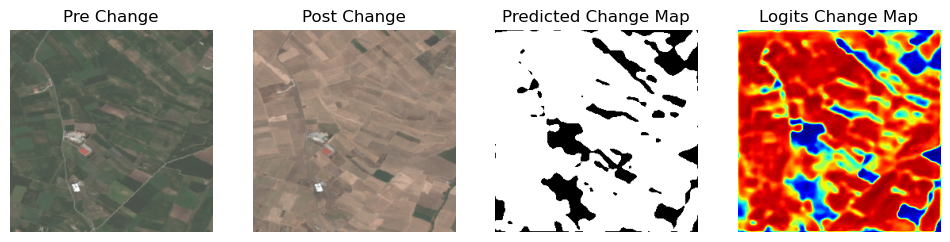

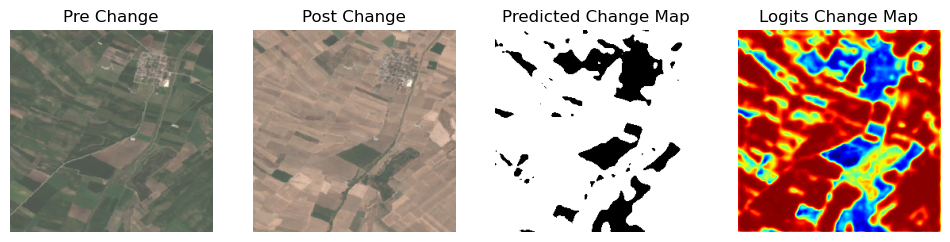

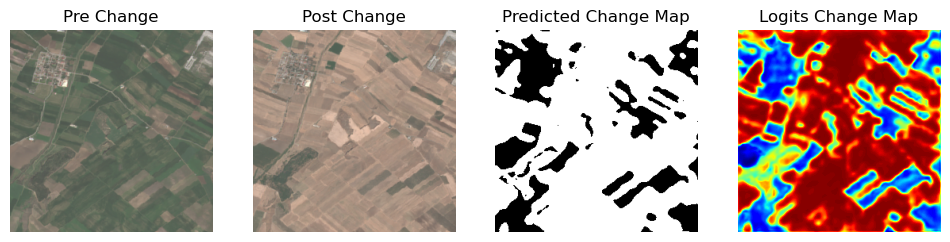

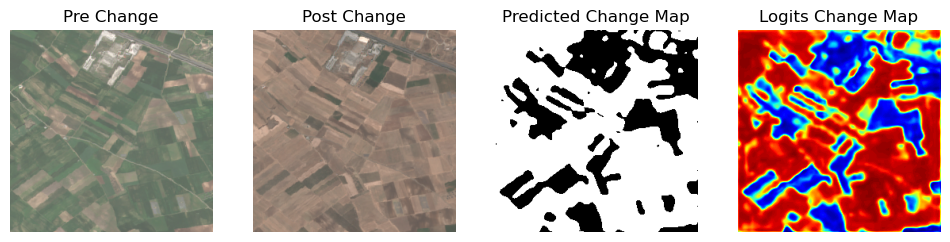

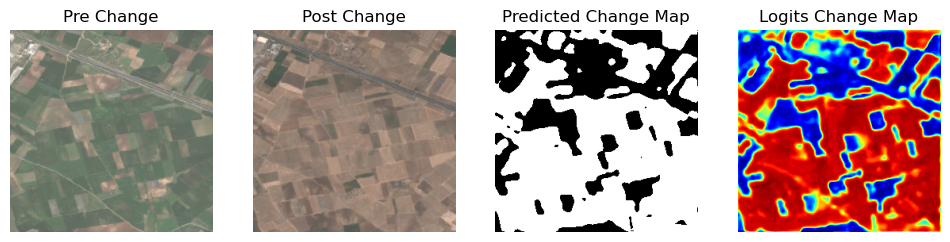

In [5]:
device = 'cpu'

for pre_image, post_image in dataloader:
    pre_image, post_image= pre_image.to(device), post_image.to(device)
    output = model(pre_image, post_image)
    prediction = torch.argmax(output, dim=1).cpu().numpy()
    prediction_logits = (torch.softmax(output, dim=1).detach().cpu().numpy()*100).astype(np.uint8)
    # prediction_logits = output.detach().cpu().numpy()
    pre_image = pre_image.permute(0, 2, 3, 1).cpu().numpy()
    post_image = post_image.permute(0, 2, 3, 1).cpu().numpy()
    for case in range(len(post_image)):
        prediction_i = prediction[case] 
        prediction_logits_i = prediction_logits[case][1]  
        pre_image_i = pre_image[case]
        post_image_i = post_image[case]
        
        # Plot the images and prediction
        plt.figure(figsize=(12, 4))
        
        # Pre-change image
        plt.subplot(1, 4, 1)
        plt.imshow(scale_rgb_image(pre_image_i[:,:,:]*15000))
        plt.title('Pre Change')
        plt.axis('off')
                
        # Post-change image
        plt.subplot(1, 4, 2)
        plt.imshow(scale_rgb_image(post_image_i[:,:,:]*15000))
        plt.title('Post Change')
        plt.axis('off')
                
        # Prediction (change/no change)
        plt.subplot(1, 4, 3)
        plt.imshow(prediction_i, cmap='gray')  # Assuming binary change detection
        plt.title('Predicted Change Map')
        plt.axis('off')
                
        plt.subplot(1, 4, 4)
        plt.imshow(prediction_logits_i, cmap='jet')  # Assuming binary change detection
        plt.title('Logits Change Map')
        plt.axis('off')
                
        plt.show()
    
    
    break

In [6]:
def predict_all_scenes_to_mosaic(model, dataset, output_dir, device='cpu'):
    model.eval()
    model.to(device)

    os.makedirs(output_dir, exist_ok=True)
    # scene_rasters = []
    # scene_rasters_logits = []

    for scene_idx in range(len(dataset.pre_scenes)):
        print(f"\nProcessing scene {scene_idx + 1}/{len(dataset.pre_scenes)}...")

        # Get metadata
        with rasterio.open(dataset.pre_scenes[scene_idx]['B04']) as ref_src:
            h, w = ref_src.height, ref_src.width
            transform = ref_src.transform
            crs = ref_src.crs

        patch_size = dataset.patch_size
        stride = dataset.stride
        full_pred = np.zeros((h, w), dtype=np.uint8)
        full_pred_logits = np.zeros((h, w), dtype=np.uint8)

        # Predict patches for this scene only
        for idx, (scene_id, y, x) in tqdm(enumerate(dataset.patch_coords), total=len(dataset.patch_coords)):
            if scene_id != scene_idx:
                continue

            pre_tensor, post_tensor = dataset[idx]
            pre_tensor = pre_tensor.unsqueeze(0).to(device)
            post_tensor = post_tensor.unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(pre_tensor, post_tensor)
                # pred_patch = torch.argmax(output, dim=1).cpu().numpy().astype(np.uint8)
                pred_patch_logits = (torch.softmax(output, dim=1).detach().cpu().numpy()[0,1,:,:]*100).astype(np.uint8)
                
            # full_pred[y:y+patch_size, x:x+patch_size] = pred_patch
            full_pred_logits[y:y+patch_size, x:x+patch_size] = pred_patch_logits
    
        full_pred_logits = full_pred_logits.astype(np.float32)

        # Standardize
        mean_val = np.mean(full_pred_logits)
        std_val = np.std(full_pred_logits)
        std_logits = (full_pred_logits - mean_val) / (std_val + 1e-8)  # avoid division by zero
        
        # Optionally scale to 0–100 for visualization
        full_pred_logits = (std_logits * 10 + 50).clip(0, 100).astype(np.uint8)

        min_val = full_pred_logits.min()
        max_val = full_pred_logits.max()
        full_pred_logits = ((full_pred_logits - min_val) / (max_val - min_val) * 100).astype(np.uint8)

        full_pred[full_pred_logits>=50] = 1
        full_pred = full_pred.astype(np.uint8)

        # Save individual scene prediction
        output_path = os.path.join(output_dir, f"scene_{scene_idx}_pred.tif")
        with rasterio.open(
            output_path, 'w',
            driver='GTiff',
            height=h, width=w,
            count=1,
            dtype=full_pred.dtype,
            crs=crs,
            transform=transform
        ) as dst:
            dst.write(full_pred, 1)

        output_path_logits = os.path.join(output_dir, f"scene_{scene_idx}_pred_logits.tif")
        with rasterio.open(
            output_path_logits, 'w',
            driver='GTiff',
            height=h, width=w,
            count=1,
            dtype=full_pred_logits.dtype,
            crs=crs,
            transform=transform
        ) as dst:
            dst.write(full_pred_logits, 1)


        # # Append to list for merging
        # scene_rasters.append(rasterio.open(output_path))
        # scene_rasters_logits.append(rasterio.open(output_path_logits))

    # # Merge all scenes into one mosaic
    # print("\nMerging all predictions into a mosaic...")
    # mosaic, out_transform = merge(scene_rasters)
    # mosaic_logits, out_transform_logits = merge(scene_rasters_logits)
    # mosaic_path = os.path.join(output_dir, "mosaic_prediction.tif")
    # mosaic_path_logits = os.path.join(output_dir, "mosaic_prediction_logits.tif")

    # # Save mosaic
    # with rasterio.open(
    #     mosaic_path, 'w',
    #     driver='GTiff',
    #     height=mosaic.shape[1],
    #     width=mosaic.shape[2],
    #     count=1,
    #     dtype=mosaic.dtype,
    #     crs=scene_rasters[0].crs,
    #     transform=out_transform
    # ) as dst:
    #     dst.write(mosaic[0], 1)

    # print(f"Mosaic saved to: {mosaic_path}")

    # with rasterio.open(
    #     mosaic_path_logits, 'w',
    #     driver='GTiff',
    #     height=mosaic_logits.shape[1],
    #     width=mosaic_logits.shape[2],
    #     count=1,
    #     dtype=mosaic_logits.dtype,
    #     crs=scene_rasters_logits[0].crs,
    #     transform=out_transform_logits
    # ) as dst:
    #     dst.write(mosaic_logits[0], 1)

    # print(f"Mosaic saved to: {mosaic_path_logits}")

In [7]:
predict_all_scenes_to_mosaic(
    model=model,
    dataset=dataset,
    output_dir='data/',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


Processing scene 1/1...


100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [01:25<00:00,  4.51it/s]
